<a href="https://colab.research.google.com/github/Robbysaidiii/Scraping_RobbySaidi_mc211d5y2136/blob/main/pelatihan_model_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Import libarary yang dibutuhkn

In [112]:
!pip install Sastrawi
!pip install tensorflow
!pip install transformers

In [129]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import re
import nltk
from nltk.corpus import stopwords
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from nltk.corpus import stopwords
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense,  Dropout
from keras.layers import Embedding, GRU, Dense, Dropout
from keras.layers import Embedding, Conv1D, GlobalMaxPooling1D, Dense, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.callbacks import Callback

In [79]:
nltk.download('punkt_tab')
nltk.download('stopwords')

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

# Memuat Dataset

In [80]:

from google.colab import drive
drive.mount('/content/drive')
df=pd.read_csv('/content/drive/MyDrive/ulasan_aplikasi_twitter.csv')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Exploratory Data Analysis (EDA)

In [81]:
df.head()

,userName,Rating,Review,Tanggal
0,Pengguna Google,2,"Banyak bug, jadi lemot (foto atau video sering...",2025-03-11 15:06:40
1,Pengguna Google,1,"Saya baru instal lagi x ini, mau login eh ""mem...",2025-03-10 14:18:48
2,Pengguna Google,1,"semenjak jadi X malah lemot, minta update seri...",2025-02-04 22:06:28
3,Pengguna Google,4,Kok banyak video permasalahan dan lemot padaha...,2025-01-15 13:22:01
4,Pengguna Google,5,"Untuk pihak X, mohon tambahkan fitur ""juga bis...",2025-03-04 18:53:12


dari dataframe diatas terdapat username, rating,review , tanggal

1.  (username) hanya berisi Pengguna Google yang artinya google menyembunyikan nama penggunna

2.   (Rating) memberika bintang sesuai dengan permasalahan user

3.  (Review) sebuah ekspersi user saat menggunkan aplikasi x/Twitter

4.  (Tanggal) setiap user yag memberika review dan rting akan tercatat tanggalnya



In [82]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45000 entries, 0 to 44999
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   userName  45000 non-null  object
 1   Rating    45000 non-null  int64 
 2   Review    45000 non-null  object
 3   Tanggal   45000 non-null  object
dtypes: int64(1), object(3)
memory usage: 1.4+ MB


dari dataframe diatas terdapat 44999 data yang berisi 4 kolom dengan tipe data 3 object dan 1 int64.... ridak ada yang missing value

In [83]:
df['Rating'].value_counts()
df['userName'].nunique()

1

In [84]:
df.shape

(45000, 4)

In [85]:
df.Review.duplicated().sum()
df.userName.duplicated().sum()

np.int64(44999)

karna di dalam username semua nya sama jadi terkena duplikat tapi saya tidak hapus duplikat karna sangat penting untuk analisis

In [86]:
df.describe(include='all')

,userName,Rating,Review,Tanggal
count,45000,45000.000000,45000,45000
unique,1,NaN,44901,44989
top,Pengguna Google,NaN,Sangat membantu,2025-03-10 15:23:42
freq,45000,NaN,12,2
mean,NaN,2.331089,NaN,NaN
std,NaN,1.657138,NaN,NaN
min,NaN,1.000000,NaN,NaN
25%,NaN,1.000000,NaN,NaN
50%,NaN,1.000000,NaN,NaN
75%,NaN,4.000000,NaN,NaN


1. userName:

Jumlah data: 45.000

Unik: 1 → Semua user bernama "Pengguna Google" (berarti Google Play menyembunyikan nama asli pengguna untuk privasi).

Frekuensi "Pengguna Google": 45.000 → semua baris.

2. Rating:
Data numerik (bisa dihitung statistiknya).

Rata-rata rating (mean) = 2.33 → dominan ulasan negatif.

Median (50%) = 1 → lebih dari setengah pengguna memberi bintang 1.

75% dari data hanya sampai bintang 4, berarti hanya sedikit yang memberi bintang 5.

3. Review:
Jumlah review unik: 44.901 dari 45.000 → artinya hampir semua review berbeda-beda, hanya sedikit yang sama.

Review paling sering muncul: "Sangat membantu" sebanyak 12 kali → kemungkinan ini adalah jawaban singkat atau template.

4. Tanggal:
Hampir semua tanggal berbeda (unik 44.989).

Ada satu tanggal yang muncul 2 kali: 2025-03-10 15:23:42.




* Mayoritas rating adalah negatif (bintang 1–2).

* Review sangat beragam, tidak banyak yang copy-paste.

* Tanggal menunjukkan data dikumpulkan dari waktu yang cukup variatif.

* Nama pengguna disamarkan oleh Google, jadi fitur userName tidak bisa dipakai untuk analisis personal.

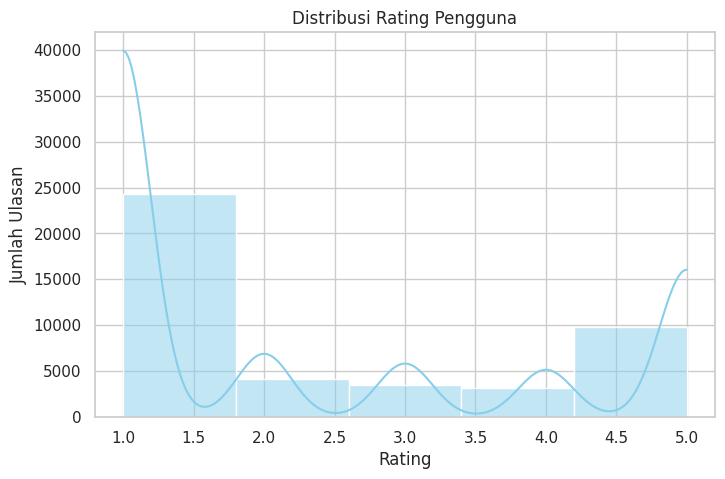

In [87]:

plt.figure(figsize=(8, 5))
sns.histplot(df['Rating'], bins=5, kde=True, color='skyblue')
plt.title('Distribusi Rating Pengguna')
plt.xlabel('Rating')
plt.ylabel('Jumlah Ulasan')
plt.show()

Mayoritas rating adalah 1 bintang — Ini menandakan banyak pengguna tidak puas dengan aplikasi (kemungkinan besar review-nya negatif).

Sedikit yang kasih 2–3 bintang — Artinya ulasan netral atau setengah-setengah itu jarang.

Rating tinggi (4–5) juga cukup signifikan — Menunjukkan ada juga yang puas atau sangat puas.

<Figure size 1000x600 with 0 Axes>

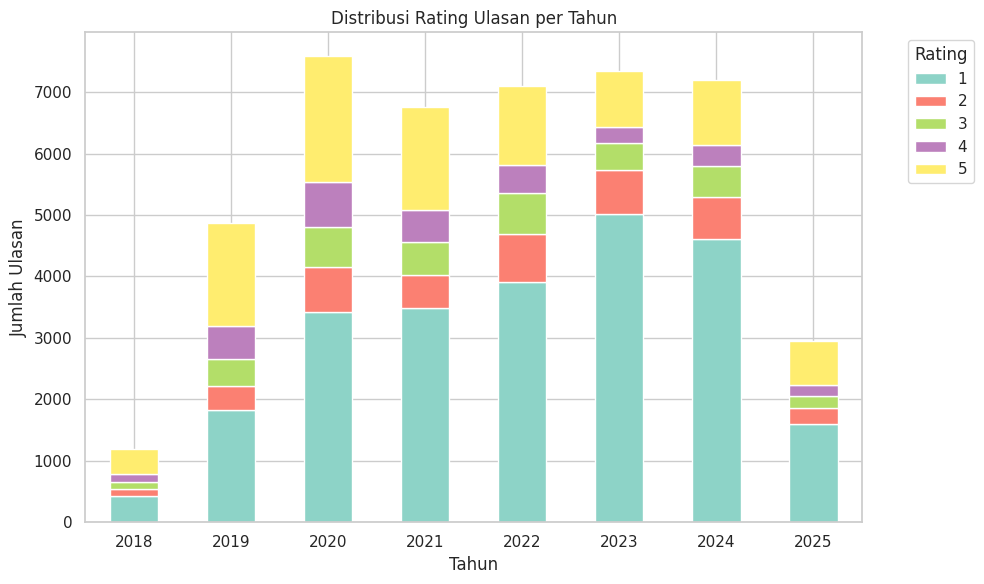

In [88]:
import matplotlib.pyplot as plt
import seaborn as sns

# Pastikan kolom Tanggal dalam format datetime
df['Tanggal'] = pd.to_datetime(df['Tanggal'], errors='coerce')

# Group by tahun dan rating
rating_per_tahun = df.groupby([df['Tanggal'].dt.year, 'Rating']).size().unstack(fill_value=0)

# Plot
plt.figure(figsize=(10, 6))
rating_per_tahun.plot(kind='bar', stacked=True, colormap='Set3', figsize=(10, 6))

plt.title("Distribusi Rating Ulasan per Tahun")
plt.xlabel("Tahun")
plt.ylabel("Jumlah Ulasan")
plt.legend(title="Rating", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()


Tahun 2020 & 2023 jadi tahun paling banyak ulasan.

Rating 1 (warna biru) mendominasi setiap tahun → ini menandakan banyak ulasan negatif dari pengguna.

Rating 5 (kuning) juga cukup signifikan di beberapa tahun, misalnya 2020 dan 2025.

Tahun 2018 masih sedikit aktivitas (wajar, mungkin awal-awal).

Tren dari 2019–2024 cukup stabil, tapi ulasan positif vs negatif masih jauh berbeda.

#  Pra-pemrosesan Teks

In [89]:
#Case Folding
df['Review'] = df['Review'].str.lower()

Mengubah semua huruf jadi huruf keci

In [90]:
#Remove Special Characters, Angka, dan Punctuation
df['Review'] = df['Review'].apply(lambda x: re.sub(r'[^a-zA-Z\s]', '', x))

Buang simbol, angka, dan tanda baca yang nggak penting.

In [91]:
#Tokenizing
df['tokens'] = df['Review'].apply(word_tokenize)

In [92]:
stop_words = set(stopwords.words('indonesian'))
df['tokens'] = df['tokens'].apply(lambda x: [word for word in x if word not in stop_words])

In [94]:
# Ambil semua kata dari seluruh token
all_words = [word for tokens in df['tokens'] for word in tokens]
unique_words = list(set(all_words))

# Stem sekali untuk tiap kata unik
stemmed_dict = {word: stemmer.stem(word) for word in unique_words}

# Replace semua token pakai dictionary
df['tokens'] = df['tokens'].apply(lambda x: [stemmed_dict[word] for word in x])


# ekstraksi fitur dan pelabelan data

In [132]:
def label_sentiment(rating):
    if rating <= 2:
        return 'negatif'
    elif rating == 3:
        return 'netral'
    else:
        return 'positif'

df['label'] = df['Rating'].apply(label_sentiment)


In [133]:
tokenizer = Tokenizer(num_words=20000)
tokenizer.fit_on_texts(df['Review'])
X_seq = tokenizer.texts_to_sequences(df['Review'])
X_seq = pad_sequences(X_seq, maxlen=100)

label_encoder = LabelEncoder()
y_seq = label_encoder.fit_transform(df['label'])

In [134]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


# algoritma pelatihan machine learning

##  LSTM / GRU / CNN

In [135]:

class StopAtAccuracy(Callback):
    def __init__(self, threshold=0.92):
        super().__init__()
        self.threshold = threshold

    def on_epoch_end(self, epoch, logs=None):
        val_acc = logs.get("val_accuracy")
        if val_acc and val_acc >= self.threshold:
            print(f"\n✅ Target akurasi {self.threshold} tercapai di epoch {epoch+1}, training dihentikan.")
            self.model.stop_training = True


In [ ]:
#Model LSTM
model_lstm = Sequential([
    Embedding(input_dim=20000, output_dim=128, input_length=100),
    LSTM(128),
    Dense(3, activation='softmax')
])
model_lstm.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model_lstm.fit(X_train, y_train, validation_data=(X_test, y_test), batch_size=64, epochs=10, callbacks=[StopAtAccuracy()])


Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


563/563 ━━━━━━━━━━━━━━━━━━━━ 232s 407ms/step - accuracy: 0.7503 - loss: 0.6596 - val_accuracy: 0.8212 - val_loss: 0.5231
Epoch 2/10
154/563 ━━━━━━━━━━━━━━━━━━━━ 1:51 272ms/step - accuracy: 0.8455 - loss: 0.4463

In [ ]:
# 🔁 Model GRU
model_gru = Sequential([
    Embedding(input_dim=20000, output_dim=128, input_length=100),
    GRU(128),
    Dense(3, activation='softmax')
])
model_gru.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model_gru.fit(X_train, y_train, validation_data=(X_test, y_test), batch_size=64, epochs=10, callbacks=[StopAtAccuracy()])


In [ ]:
# 🔁 Model CNN
model_cnn = Sequential([
    Embedding(input_dim=20000, output_dim=128, input_length=100),
    Conv1D(128, kernel_size=5, activation='relu'),
    BatchNormalization(),
    GlobalMaxPooling1D(),
    Dense(3, activation='softmax')
])
model_cnn.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model_cnn.fit(X_train, y_train, validation_data=(X_test, y_test), batch_size=64, epochs=10, callbacks=[StopAtAccuracy()])


##  TF-IDF + CNN

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(max_features=20000)
X_tfidf = tfidf.fit_transform(df['Review']).toarray()

X_train2, X_test2, y_train2, y_test2 = train_test_split(X_tfidf, y_seq, test_size=0.2, random_state=42)

# Jika ingin deep learning, reshape agar ada dimensi channel
X_train2 = X_train2.reshape(X_train2.shape[0], X_tfidf.shape[1], 1)
X_test2 = X_test2.reshape(X_test2.shape[0], X_tfidf.shape[1], 1)

# Model CNN dengan TF-IDF
model_tfidf_cnn = Sequential([
    Conv1D(64, kernel_size=3, activation='relu', input_shape=(X_tfidf.shape[1], 1)),
    GlobalMaxPooling1D(),
    Dense(3, activation='softmax')
])
model_tfidf_cnn.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model_tfidf_cnn.fit(X_train2, y_train2, validation_data=(X_test2, y_test2), epochs=10, callbacks=[StopAtAccuracy()])


## BERT + IndoBERT

In [ ]:
from transformers import BertTokenizer, TFBertForSequenceClassification
from tensorflow.keras.utils import to_categorical

bert_tokenizer = BertTokenizer.from_pretrained('indobenchmark/indobert-base-p1')
X_bert = bert_tokenizer(df['Review'].tolist(), truncation=True, padding=True, max_length=100, return_tensors='tf')
y_bert = to_categorical(label_encoder.transform(df['label']), num_classes=3)

X_train_b, X_test_b, y_train_b, y_test_b = train_test_split(X_bert['input_ids'], y_bert, test_size=0.2, stratify=label_encoder.transform(df['label']), random_state=42)

model_bert = TFBertForSequenceClassification.from_pretrained('indobenchmark/indobert-base-p1', num_labels=3)
model_bert.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=2e-5), loss='categorical_crossentropy', metrics=['accuracy'])
model_bert.fit(X_train_b, y_train_b, validation_data=(X_test_b, y_test_b), epochs=5, batch_size=16, callbacks=[StopAtAccuracy()])


In [ ]:
# Evaluasi
loss, acc = model_lstm.evaluate(X_test, y_test)
print(f"LSTM Accuracy: {acc:.2%}")
model_lstm.save('models/model_lstm.h5')

# Ulangi untuk model lainnya
